In [74]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [75]:
spark = SparkSession.builder.appName("a5").getOrCreate()
csv_file = "gs://dataproc-staging-us-central1-823943063357-inh6zdl6/data/light_spotify_dataset.csv"
df = spark.read.csv(csv_file, 
                    header=True,
                    inferSchema=True)
df.select("Popularity", 
          "Key", 
          "variance",
          "Tempo", 
          "Loudness", 
          "Energy", 
          "Danceability", 
          "Positiveness", 
          "Speechiness", 
          "Liveness", 
          "Acousticness", 
          "Instrumentalness").show(10)

+----------+------+--------------------+-----+--------+------+------------+------------+-----------+--------+------------+----------------+
|Popularity|   Key|            variance|Tempo|Loudness|Energy|Danceability|Positiveness|Speechiness|Liveness|Acousticness|Instrumentalness|
+----------+------+--------------------+-----+--------+------+------------+------------+-----------+--------+------------+----------------+
|        31| F Maj|  0.4476190476190476|  128|    -6.0|    78|          56|          60|          3|      31|           7|               0|
|        59|A# Maj| 0.20222222222222216|  102|  -10.72|    36|          52|          38|          2|       7|          68|               0|
|        50| E Maj|  0.3008807588075881|  139|    -5.7|    78|          85|          97|          3|       8|          20|               2|
|        52| F Maj|               0.355|  132|    -3.0|    76|          50|          89|          3|      32|           3|               0|
|        52| F Maj| 

In [76]:
# Input features
input_cols = ["variance",
               "Tempo", 
               "Loudness",
               "Energy", 
               "Danceability", 
               "Positiveness", 
               "Speechiness", 
               "Liveness", 
               "Acousticness", 
               "Instrumentalness"]
# Prediction
target_col = "Popularity"

s_df = df.select(input_cols + [target_col]).dropna()
s_df = s_df.withColumn("Tempo", col("Tempo").cast("double"))
s_df = s_df.withColumn("variance", col("variance").cast("double"))
s_df = s_df.withColumn("Popularity", col("Popularity").cast("double"))

In [77]:
# Split the data into training and testing sets
trainDF, testDF = s_df.randomSplit([0.8, 0.2], seed=42)
print(f"""There are {trainDF.count()} rows in the training set, and {testDF.count()} in the test set""")

There are 189773 rows in the training set, and 47215 in the test set


In [78]:
# Create pipeline and fit the model
vecAssembler = VectorAssembler(handleInvalid="skip", inputCols=input_cols, outputCol='features')

gbt = GBTRegressor(labelCol="Popularity", featuresCol="features")

pipeline = Pipeline(stages=[vecAssembler, gbt])
model = pipeline.fit(trainDF)
predictions = model.transform(testDF)

In [79]:
# Evaluate the model
regressionEvaluator = RegressionEvaluator(
    predictionCol="prediction",
    labelCol="Popularity",
    metricName="rmse"
)
rmse = regressionEvaluator.evaluate(predictions)
print(f"RMSE: {rmse}")

RMSE: 17.625641663292598


In [80]:
# Extract how important each feature is
f_importance = model.stages[-1].featureImportances
importance_val = f_importance.toArray().tolist()
importanceDF = pd.DataFrame({'Feature': input_cols,
                             'Importance': importance_val})
importanceDF = importanceDF.sort_values(by='Importance', ascending=False)
print(importanceDF)

            Feature  Importance
2          Loudness    0.152328
6       Speechiness    0.124364
0          variance    0.122356
8      Acousticness    0.108205
3            Energy    0.105065
1             Tempo    0.096024
5      Positiveness    0.095273
4      Danceability    0.094049
7          Liveness    0.068588
9  Instrumentalness    0.033747


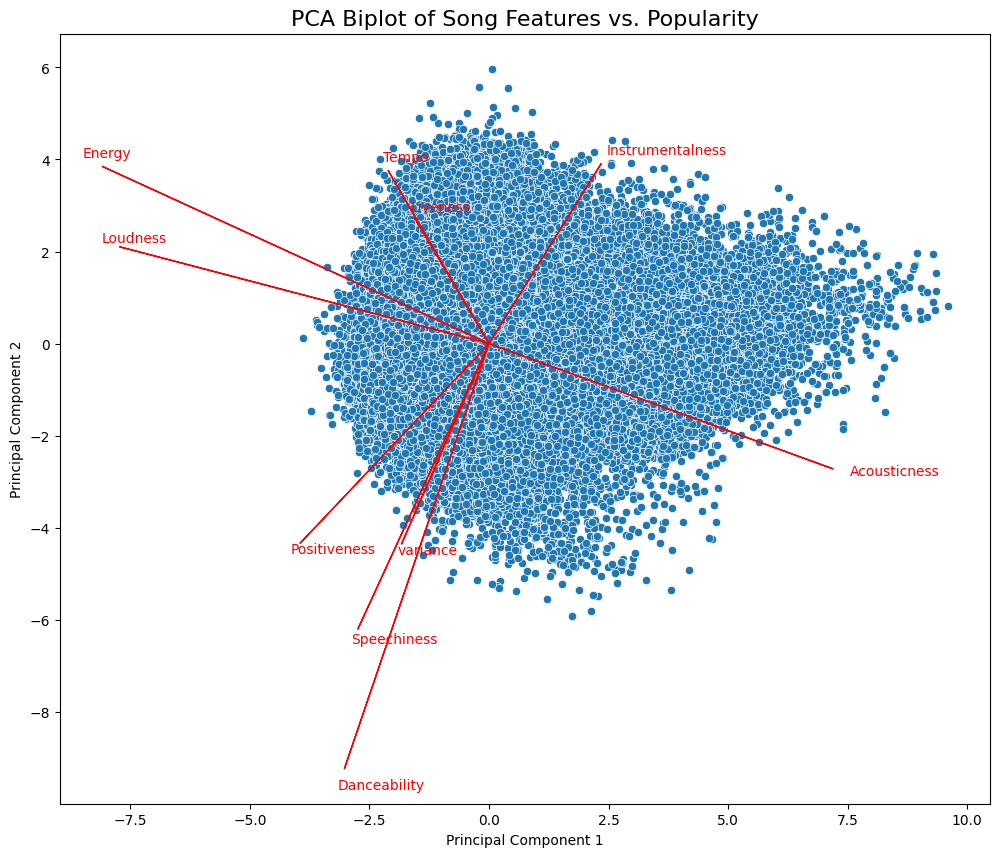

In [81]:
# PCA Biplot to visualize each feature's importance
assembled_df = vecAssembler.transform(s_df)

pandas_df = assembled_df.select(input_cols + [target_col]).toPandas()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(pandas_df[input_cols])

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df[target_col] = pandas_df[target_col]

plt.figure(figsize=(12, 10))
scatter = sns.scatterplot(x='PC1', y='PC2', data=pca_df)

feature_vectors = pca.components_.T
scaled_vectors = feature_vectors * 15

for i, feature in enumerate(input_cols):
    plt.arrow(0, 0, scaled_vectors[i, 0], scaled_vectors[i, 1], color='red')
    plt.text(scaled_vectors[i, 0] * 1.05, scaled_vectors[i, 1] * 1.05, feature, color='red', fontsize=10)

plt.xlabel(f'Principal Component 1')
plt.ylabel(f'Principal Component 2')
plt.title('PCA Biplot of Song Features vs. Popularity', fontsize=16)
plt.show()


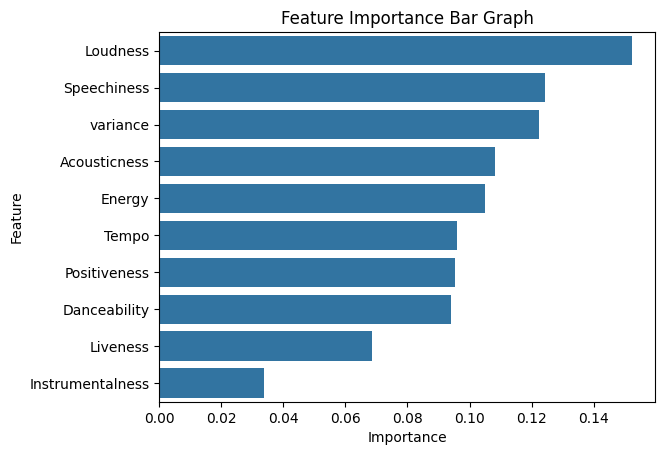

In [82]:
# Bar Plot for feature importance
sns.barplot(x='Importance', y='Feature', data=importanceDF)
plt.title("Feature Importance Bar Graph")
plt.show()